# Gregors

## Context
Gregors is a B2B2C product and partners with lenders and background screening agencies to help
complete Income and Employment verification needs.
As part of this process the end user accesses either Gregors’s widget embedded in our client’s portal or an order form sent via email or SMS, where they do the following-

1. Search for their employer that they work at currently

2. When a user starts typing we use our internal database of employers; if the employer is
not found, the user is presented with google API results (first two rows) or manual entry
(last row), see screenshot below.

3. Once a user selects an employer, they can either see the Payroll provider login screen
(mapped employers) or see a list of payroll providers.

4. Once a user submits their credentials, they end in either Success or Error when user is
let go

| variable                                | sample                      | description                                                                                                  |   |   |
|-----------------------------------------|-----------------------------|--------------------------------------------------------------------------------------------------------------|---|---|
| Client Domain                           | A                           | Client Name                                                                                                  |   |   |
| User Phone Timezone                     | Unknown                     | User device time zone (Unknown: we failed to capture the timezone)                                           |   |   |
| Created At                              | 2023-03-27T20:44:47.283091Z | Date in which the order was created                                                                          |   |   |
| Email Clicks                            |                           0 | Clicks in email links                                                                                        |   |   |
| Email Opens                             |                           0 | Emails that were opened                                                                                      |   |   |
| Emails                                  |                           4 | Emails sent                                                                                                  |   |   |
| Expired                                 |                           1 | Number of expired orders                                                                                     |   |   |
| Order Funnel State                      | 2-Notification sent         | Order state                                                                                                  |   |   |
| Sms                                     |                           0 | SMS sent                                                                                                     |   |   |
| Sms Clicks                              |                           0 | SMS clicked                                                                                                  |   |   |
| Sms Opens                               |                           0 | SMS opened                                                                                                   |   |   |
| Platforms Order Group - Order → Manager | masked@order_manager.org    | Email of the order manager                                                                                   |   |   |
| Platforms Order Group - Order → Source  | internal                    |                                                                                                              |   |   |
| order_has_user_email                    |             TRUE            | If the user´s email was present in the order form (this is used to contact the user and ask them to verify). |   |   |
| order_has_user_phone                    |            FALSE            | If the user´s phone was present in the order form (this is used to contact the user and ask them to verify). |   |   |


The variable “Order Funnel State” tracks the following actions from users:
1. Created: order gets created
2. Notification sent : a notification is sent to the user that wants to verify their information
3. Notification opened: the notification is opened by the user
4. Notification click: the link within the email/message is clicked (this link opens our widget)
5. Widget loaded: the widget is loaded by the user
6. Employer selected: the user searches and selects an employer
7. Viewed provider login: user views the provider login page
8. Submitted login: user submits their credentials
9. Completed: user is able to successfully login to their employer and verify their information

## Problem Statement
Our north star metric is “Conversion Rate” which is the ratio of users that successfully complete a verification (Order Funnel State = “9-Completed”).

**One of our clients reaches out complaining about a drop in CR and wants recomendations on how to improve it.**

## Task
Analyze the following the dataset and:
* Figure out if conversion rate has in fact dropped and, if such, explain why it dropped
* Provide recommendations on how to improve conversion rate

## Deliverables
Presentation with findings and recommendations
Proposal on how to prevent this from happening in the future


## Dataset

https://docs.google.com/spreadsheets/d/1appaNdbUMIMlA_j6bgnlCWURon7TODALquTU-UyGmoY/edit?usp=sharing


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



# First Step: Data Validation
**Objective:**
Before diving into any analysis, the first and foremost step is to validate the dataset for its integrity, consistency, and completeness. This is crucial for ensuring that the subsequent analyses and insights are based on reliable data.

Actions to Take:
1. Check for Missing Values: Identify any missing or null values in the dataset that could affect the analysis. This is especially important for key variables like 'Order Funnel State', 'Email Clicks', 'Email Opens', etc.

2. Funnels Consistency: Validate the logical flow of the 'Order Funnel State'. For example, an order should not be in the 'Notification Clicked' state without first being in the 'Notification Sent' and 'Notification Opened' states.

3. Email and SMS Metrics: Examine the email and SMS related variables to identify any inconsistencies. For instance, there should not be any 'Email Clicks' without corresponding 'Email Opens' and 'Emails Sent'.

Why This Step is Important:
* Data Integrity: Ensuring that there are no missing or inconsistent data points allows for a more accurate and reliable analysis.

* Identify Anomalies: Early identification of any inconsistencies or anomalies will help in either correcting the data or accounting for such issues in the analysis.

* Foundation for Analysis: A validated dataset lays a strong foundation for the subsequent steps in the analysis, ensuring that the insights and recommendations are trustworthy.

By meticulously validating the data, we set the stage for a robust analysis aimed at understanding the drop in Conversion Rate (CR) and proposing actionable recommendations for improvement.

In [2]:
df = pd.read_csv("/Users/lolonastri/Desktop/POO_UCEMA/machine_learning/4-communication/gregors.csv")

# Data Validation

In [3]:
df["User Phone Timezone"].value_counts(normalize=True)

User Phone Timezone
CST        0.577017
EST        0.313447
Unknown    0.061125
PST        0.031296
MST        0.013203
AST        0.001956
UTC-10     0.001222
UTC-9      0.000733
Name: proportion, dtype: float64

In [4]:
df_sample = df.sample(10)

In [5]:
df_sample["User Phone Timezone"].value_counts(normalize=True)

User Phone Timezone
CST    0.6
EST    0.4
Name: proportion, dtype: float64

## Missing treatment



In [6]:
df[df["Sms"].isna()][["Order Funnel State","Email Opens","Sms Opens"]].value_counts()

Order Funnel State  Email Opens  Sms Opens
1-Created           0            0            16
Name: count, dtype: int64

In [7]:
df[df["Emails"].isna()][["Order Funnel State","Email Opens","Sms Opens"]].value_counts()

Order Funnel State  Email Opens  Sms Opens
1-Created           0            0            16
Name: count, dtype: int64

We have missing values in Emails/Sms  in a erly stage of the funnel and also the percentage of missing values is very low and there are not edge cases. So we can drop that examples

In [8]:
df = df.dropna(subset="Emails")
df[df["Emails"].isna()].shape

(0, 15)

In [9]:
df.dropna(subset="Sms",inplace=True)

In [10]:
df.Sms.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
4085    False
4086    False
4087    False
4088    False
4089    False
Name: Sms, Length: 4074, dtype: bool

In [11]:
df = df.dropna(subset="Sms")

## Dtypes

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4074 entries, 0 to 4089
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Client Domain                            4074 non-null   object 
 1   User Phone Timezone                      4074 non-null   object 
 2   Created At                               4074 non-null   object 
 3   Email Clicks                             4074 non-null   int64  
 4   Email Opens                              4074 non-null   int64  
 5   Emails                                   4074 non-null   float64
 6   Expired                                  4074 non-null   int64  
 7   Order Funnel State                       4074 non-null   object 
 8   Sms                                      4074 non-null   float64
 9   Sms Clicks                               4074 non-null   int64  
 10  Sms Opens                                4074 non-nul

We can see the balance of the categorical columns

In [13]:
df["Client Domain"].value_counts()

Client Domain
A    4074
Name: count, dtype: int64

In [14]:
df["order_has_user_email"].value_counts()

order_has_user_email
False    2736
True     1338
Name: count, dtype: int64

In [15]:
df["order_has_user_phone"].value_counts()

order_has_user_phone
True     3835
False     239
Name: count, dtype: int64

There are orders that dont have user phone either email. We need to check that possible inconsistency

In [16]:
df[["order_has_user_phone","order_has_user_email"]].value_counts()

order_has_user_phone  order_has_user_email
True                  False                   2736
                      True                    1099
False                 True                     239
Name: count, dtype: int64

## Funnel Consistency

Extract the numerical order of the funnel state

In [17]:
df['Order Funnel State'].value_counts()

Order Funnel State
2-Notification sent        996
8-Submitted login          869
9-Completed                627
7-Viewed provider login    609
6-Employer selected        395
5-Widget loaded            291
3-Notification opened      150
4-Notification click       137
Name: count, dtype: int64

In [18]:
"3-Notification opened".split("-")[0]

'3'

In [19]:
def separar_guion(x):
    return x.split("-")[0]

df['Order Funnel State'].apply(separar_guion)

0       2
1       3
2       8
3       5
4       8
       ..
4085    8
4086    9
4087    9
4088    8
4089    6
Name: Order Funnel State, Length: 4074, dtype: object

In [20]:
df['funnel_order'] = df['Order Funnel State'].apply(lambda x: int(x.split('-')[0]))
df['funnel_order'].value_counts()

funnel_order
2    996
8    869
9    627
7    609
6    395
5    291
3    150
4    137
Name: count, dtype: int64

We don´t expected to have a Sms not send == 0, and and Sms Open. Also we dont expected an Sms Open and not click

In [21]:
print(sorted(df['Order Funnel State'].unique()))

['2-Notification sent', '3-Notification opened', '4-Notification click', '5-Widget loaded', '6-Employer selected', '7-Viewed provider login', '8-Submitted login', '9-Completed']


**Inconsistent Funnel" 
* '3-Notification opened': The rows with funnel >2 and without emails open
* ''4-Notification click'': The rows with funnel >3 and without emails Click

In [22]:
Emails_sent = df.groupby(['funnel_order', 'Emails']).agg(count_open=('Email Opens', 'sum'), count_click=('Email Clicks', 'sum')).reset_index()
Emails_sent

,funnel_order,Emails,count_open,count_click
0,2,0.0,0,0
1,2,1.0,0,0
2,2,2.0,0,0
3,2,4.0,0,0
4,3,1.0,2,0
5,3,4.0,409,0
6,4,0.0,0,0
7,4,1.0,2,3
8,4,4.0,29,6
9,5,0.0,0,0


In [23]:
Sms_sent = df.groupby(['funnel_order', 'Sms']).agg(count_open=('Sms Opens', 'sum'), count_click=('Sms Clicks', 'sum')).reset_index()

### Emails sent == 0

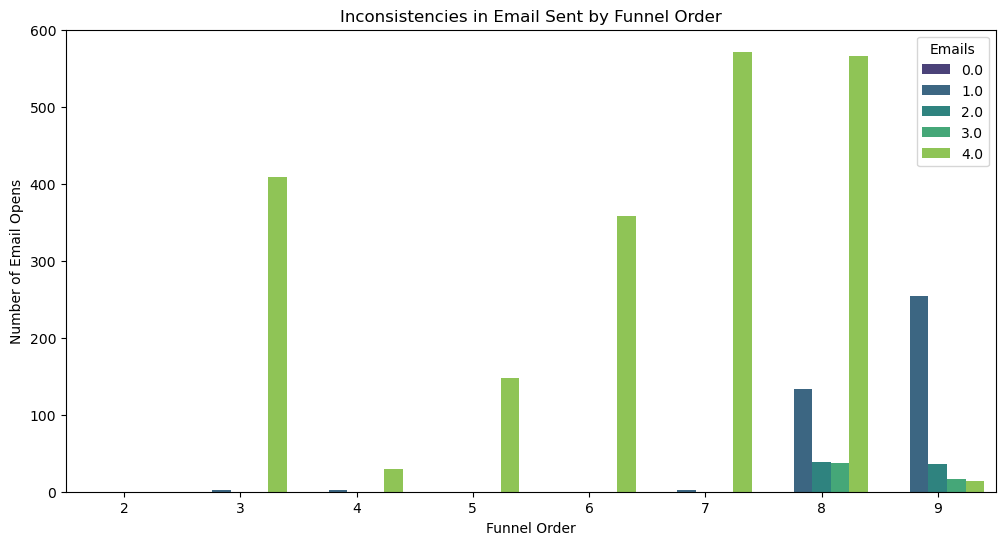

In [24]:
# Plotting Email inconsistencies
plt.figure(figsize=(12, 6))
sns.barplot(x='funnel_order', y='count_open', hue='Emails', data=Emails_sent, palette='viridis')
plt.title('Inconsistencies in Email Sent by Funnel Order')
plt.xlabel('Funnel Order')
plt.ylabel('Number of Email Opens')
plt.show()


### Emails Sent and Sms Sent == 0.  With funnel state > 3 


In [25]:
df["Order Funnel State"].unique()

array(['2-Notification sent', '3-Notification opened',
       '8-Submitted login', '5-Widget loaded', '4-Notification click',
       '9-Completed', '6-Employer selected', '7-Viewed provider login'],
      dtype=object)

In [26]:
inconsistent_funnel_3 = df[((df['funnel_order'] > 2) & (df['Email Opens'] == 0) & (df['Sms Opens'] == 0))]
inconsistent_funnel_3

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,Sms Opens,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone,funnel_order
78,A,Unknown,2022-10-28T14:27:19.596959Z,1,0,1.0,0,4-Notification click,0.0,0,0,masked@order_manager.org,internal,True,False,4
146,A,Unknown,2022-09-14T16:09:45.450499Z,2,0,4.0,1,7-Viewed provider login,0.0,0,0,masked@order_manager.org,internal,True,False,7
194,A,EST,2023-01-20T19:03:11.624372Z,2,0,4.0,1,6-Employer selected,1.0,1,0,masked@order_manager.org,internal,True,True,6
199,A,EST,2022-10-06T15:17:54.164108Z,0,0,0.0,1,6-Employer selected,1.0,1,0,masked@order_manager.org,internal,False,True,6
200,A,EST,2022-12-12T14:24:39.440022Z,0,0,1.0,0,8-Submitted login,1.0,1,0,masked@order_manager.org,internal,True,True,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,A,CST,2022-07-14T18:19:03.889063Z,0,0,4.0,1,8-Submitted login,1.0,1,0,masked@order_manager.org,internal,True,True,8
4034,A,CST,2022-08-18T20:30:09.688551Z,0,0,0.0,1,7-Viewed provider login,1.0,1,0,masked@order_manager.org,internal,False,True,7
4035,A,EST,2022-10-27T18:09:06.743787Z,0,0,0.0,1,7-Viewed provider login,1.0,1,0,masked@order_manager.org,internal,False,True,7
4036,A,EST,2023-02-28T16:42:12.938568Z,0,0,0.0,1,4-Notification click,1.0,1,0,masked@order_manager.org,internal,False,True,4


In [27]:
inconsistent_funnel_3['Order Funnel State'].value_counts()

Order Funnel State
8-Submitted login          534
7-Viewed provider login    430
9-Completed                343
6-Employer selected        287
5-Widget loaded            248
4-Notification click       124
Name: count, dtype: int64

### Emails Clicks == 0

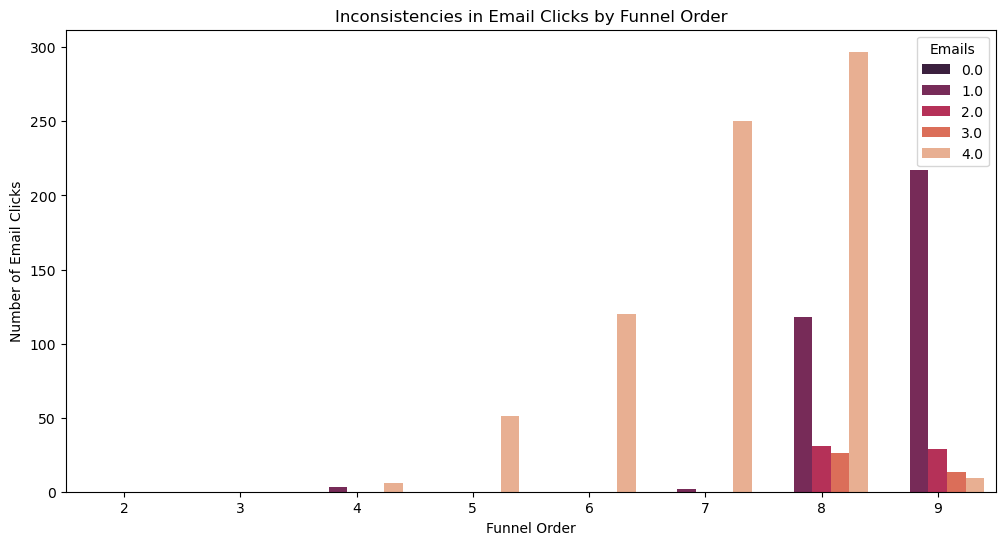

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x='funnel_order', y='count_click', hue='Emails', data=Emails_sent, palette='rocket')
plt.title('Inconsistencies in Email Clicks by Funnel Order')
plt.xlabel('Funnel Order')
plt.ylabel('Number of Email Clicks')
plt.show()

### Emails Clicks and Sms Clicks == 0.  With funnel state > 3 

In [29]:
df["Order Funnel State"].unique()

array(['2-Notification sent', '3-Notification opened',
       '8-Submitted login', '5-Widget loaded', '4-Notification click',
       '9-Completed', '6-Employer selected', '7-Viewed provider login'],
      dtype=object)

In [30]:
inconsistent_funnel_4 = df[((df['funnel_order'] >= 4) & (df['Email Clicks'] == 0) & (df['Sms Clicks'] == 0))]
inconsistent_funnel_4

,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,Sms Opens,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone,funnel_order
164,A,Unknown,2022-09-02T21:31:54.085502Z,0,4,4.0,1,7-Viewed provider login,0.0,0,0,masked@order_manager.org,internal,True,False,7
179,A,Unknown,2022-09-08T17:48:28.880669Z,0,2,4.0,1,6-Employer selected,0.0,0,0,masked@order_manager.org,internal,True,False,6
1483,A,EST,2022-07-05T14:49:39.580578Z,0,3,4.0,1,7-Viewed provider login,1.0,0,0,masked@order_manager.org,internal,True,True,7
1613,A,CST,2022-08-12T20:12:05.020255Z,0,3,4.0,1,6-Employer selected,1.0,0,0,masked@order_manager.org,internal,True,True,6


### These inconsistencies can affect the conversion rate, client satisfaction, and the overall integrity of the analytics. Here's a proposed treatment for each type of inconsistency:

1. SMS or Email Opened but Not Sent
Treatment: Flag these records for manual review. It's crucial to understand why the system shows an SMS or email as opened but not sent. If it's a system error, it needs immediate attention.
2. SMS or Email Clicked but Not Opened
Treatment: Similar to the above, flag these for manual review. This could be a tracking issue where the 'open' event is not being captured correctly.
3. Advanced Funnel State without Preceding States
Treatment: These records should be flagged and reviewed to understand why they skipped the initial funnel states. It could be a system issue or user behavior that needs to be understood.

In [31]:
consistent_funnel = df[~((df['funnel_order'] > 2) & (df['Email Opens'] == 0) & (df['Sms Opens'] == 0))]

# Filter out records where SMS or Email is clicked but not opened
consistent_funnel = consistent_funnel[~((consistent_funnel['Sms Clicks'] > 0) & (consistent_funnel['Sms Opens'] == 0))]
consistent_funnel = consistent_funnel[~((consistent_funnel['Email Clicks'] > 0) & (consistent_funnel['Email Opens'] == 0))]


In [32]:
print(f"The len of the original datframe is {len(df)} and the new dataframe has len {len(consistent_funnel)}. A diference that is {len(df)-len(consistent_funnel)} and represent {((len(df)-len(consistent_funnel))/len(df))*100:.2f}% of the original dataframe")

The len of the original datframe is 4074 and the new dataframe has len 1611. A diference that is 2463 and represent 60.46% of the original dataframe


Given the context of Gregors, a B2B2C product that deals with income and employment verification, data inconsistencies can have significant implications. These inconsistencies can affect the conversion rate, client satisfaction, and the overall integrity of the analytics. 

So we are going to analize conversion rate with both dataset and check if we see the same pattern

In [33]:
#df = consistent_funnel

# Conversion Rate Analysis

We are going to compare the conversion rate along the time that the order was created. So first we need to handle the datetime col

In [34]:
# Convert 'Created At' to datetime format
df['Created At'] = pd.to_datetime(df['Created At'])
# Extract day, month, and year
df['Day'] = df['Created At'].dt.day
df['Month'] = df['Created At'].dt.month
df['Year'] = df['Created At'].dt.year

In [35]:

# Function to calculate and plot conversion rate
def plot_conversion_rate(df, title):
    completed_df = df[df['Order Funnel State'] == '9-Completed']
    completed_grouped = completed_df.groupby(['Year', 'Month']).size().reset_index(name='Completed_Count')
    total_grouped = df.groupby(['Year', 'Month']).size().reset_index(name='Total_Count')
    conversion_df = pd.merge(total_grouped, completed_grouped, on=['Year', 'Month'], how='left').fillna(0)
    conversion_df['Conversion_Rate'] = (conversion_df['Completed_Count'] / conversion_df['Total_Count']) * 100
    conversion_df['Year_Month'] = conversion_df['Year'].astype(str) + '-' + conversion_df['Month'].astype(str).str.zfill(2)
    
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='Year_Month', y='Conversion_Rate', data=conversion_df, marker='o')
    plt.title(title)
    plt.xlabel('Year-Month')
    plt.ylabel('Conversion Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


## Original df analysis

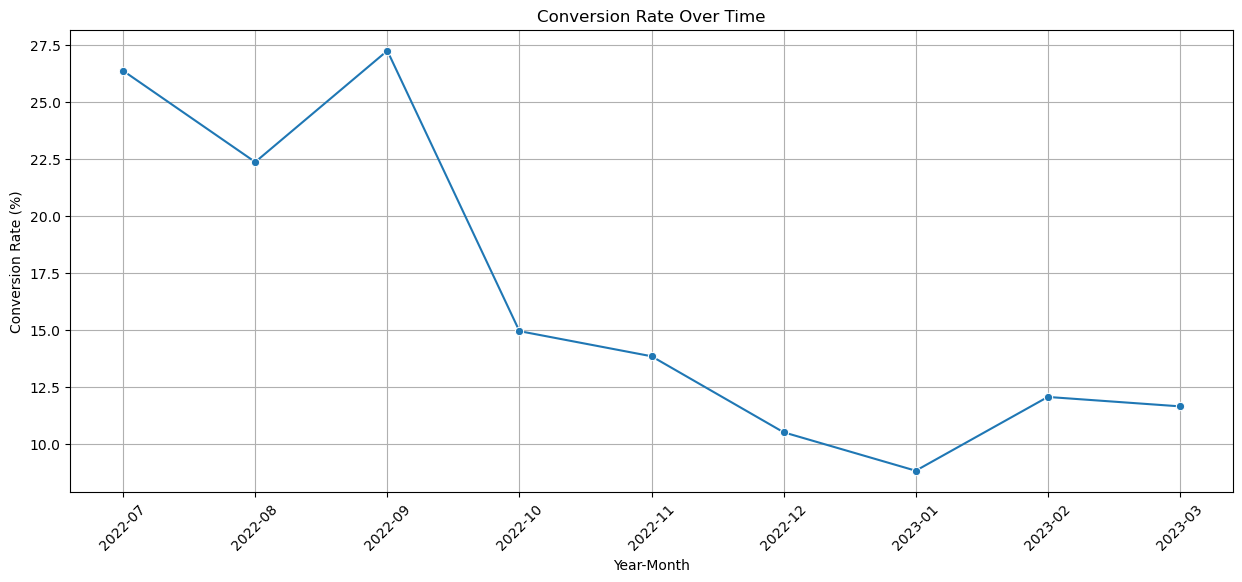

In [36]:
plot_conversion_rate(df, 'Conversion Rate Over Time')

## Conv rate of emal vs clicks

In [37]:
# Filter data for email interactions
email_df = df[(df['Sms Clicks'] == 0) & (df['Email Clicks'] > 0)]

# Filter data for SMS interactions
sms_df = df[(df['Email Clicks'] == 0) & (df['Sms Clicks'] > 0)]

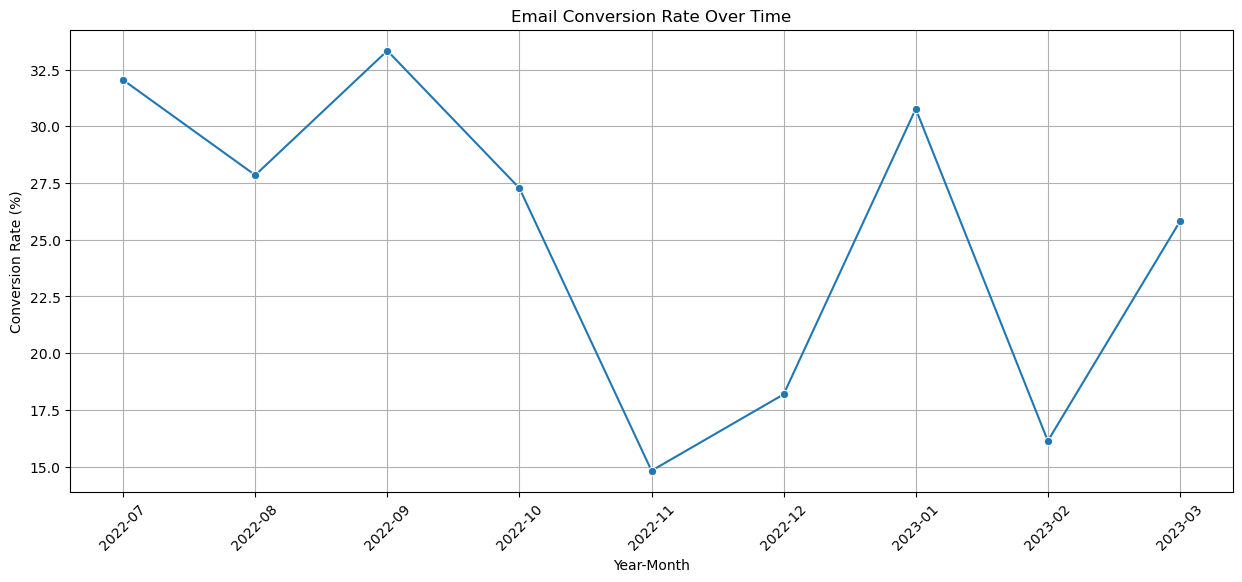

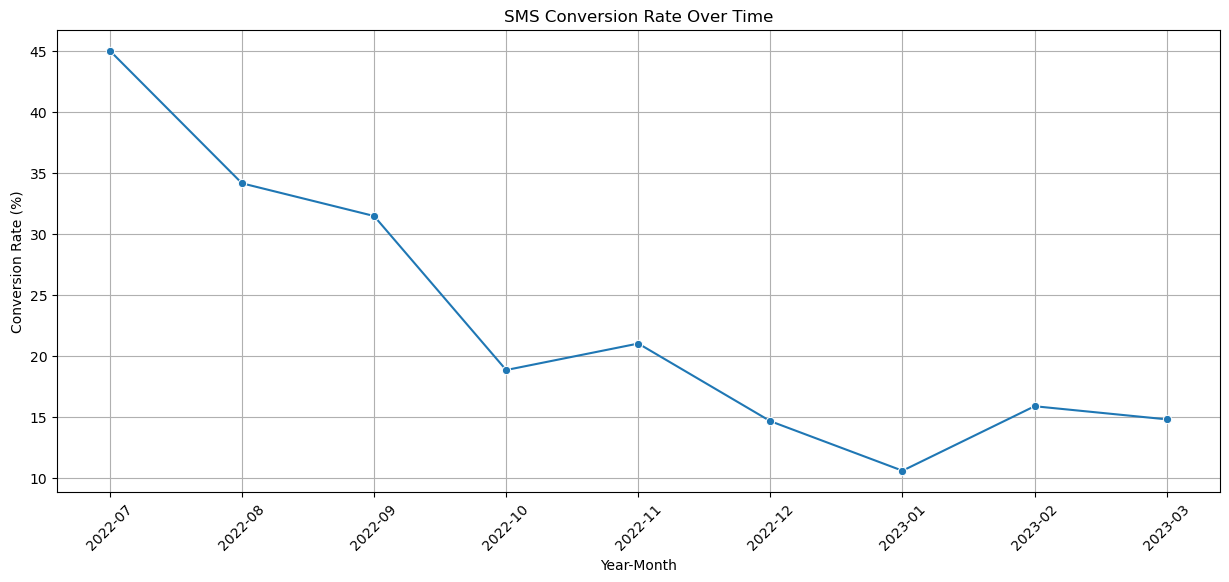

In [38]:


# Plot conversion rate for email interactions
plot_conversion_rate(email_df, 'Email Conversion Rate Over Time')

# Plot conversion rate for SMS interactions
plot_conversion_rate(sms_df, 'SMS Conversion Rate Over Time')


When we analyze the conv rate 

## What we pressume 'consistent" df

In [39]:
# Convert 'Created At' to datetime format
consistent_funnel['Created At'] = pd.to_datetime(consistent_funnel['Created At'])
# Extract day, month, and year
consistent_funnel['Day'] = consistent_funnel['Created At'].dt.day
consistent_funnel['Month'] = consistent_funnel['Created At'].dt.month
consistent_funnel['Year'] = consistent_funnel['Created At'].dt.year
# Extract hour and minute
consistent_funnel['Hour'] = consistent_funnel['Created At'].dt.hour
consistent_funnel['Minute'] = consistent_funnel['Created At'].dt.minute

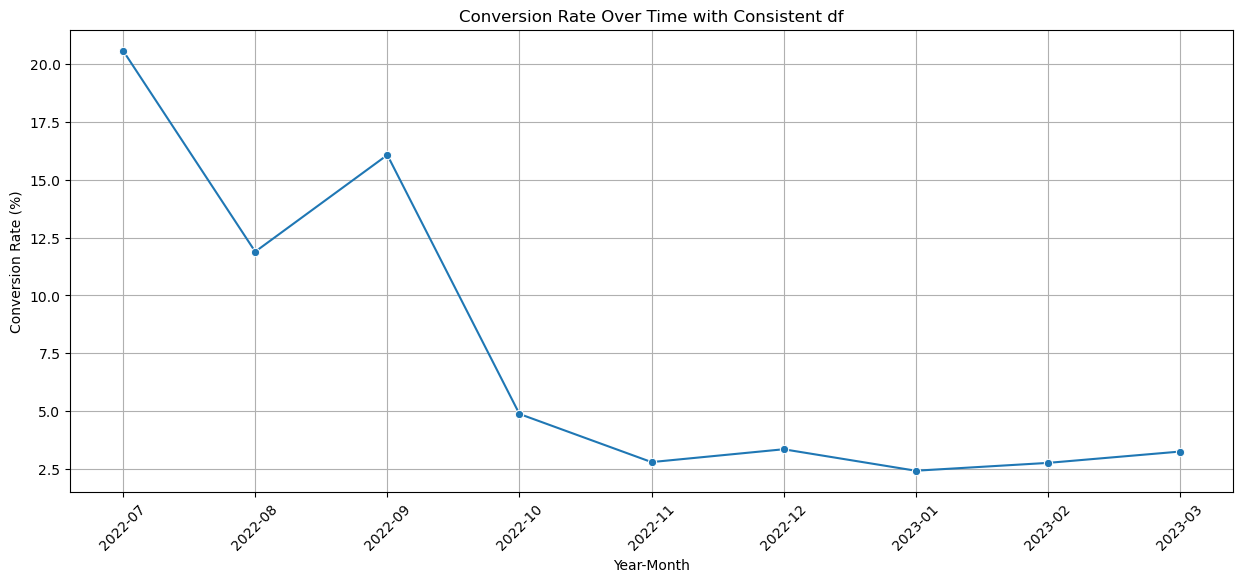

In [40]:

plot_conversion_rate(consistent_funnel, 'Conversion Rate Over Time with Consistent df')

/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/4072210197.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  email_df = consistent_funnel[(df['Sms Clicks'] == 0) & (consistent_funnel['Email Clicks'] > 0)]


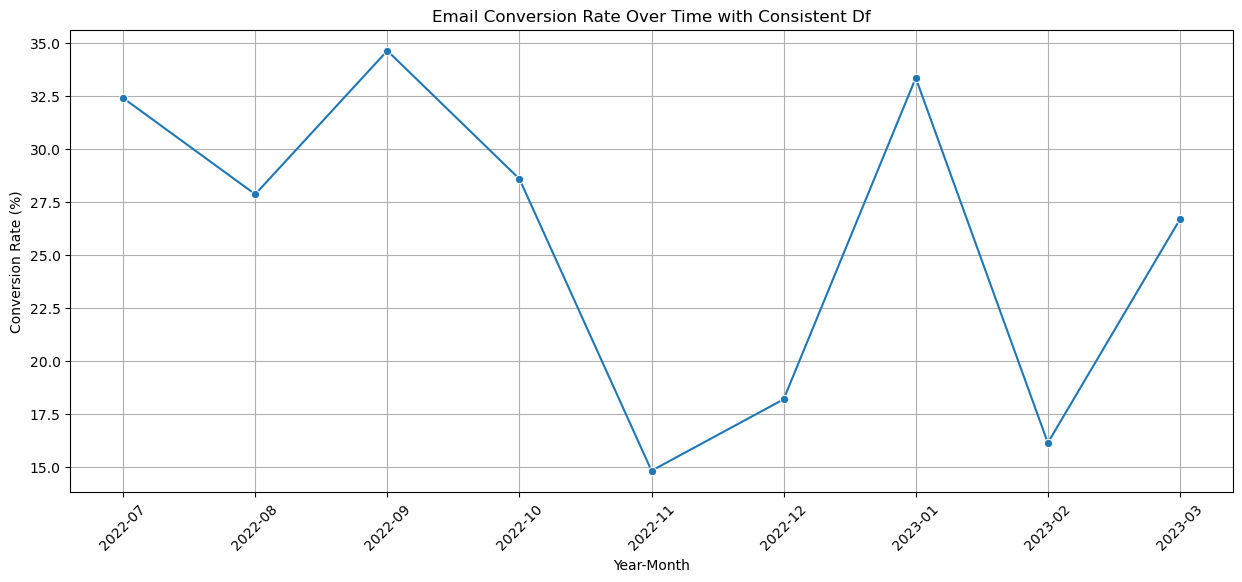

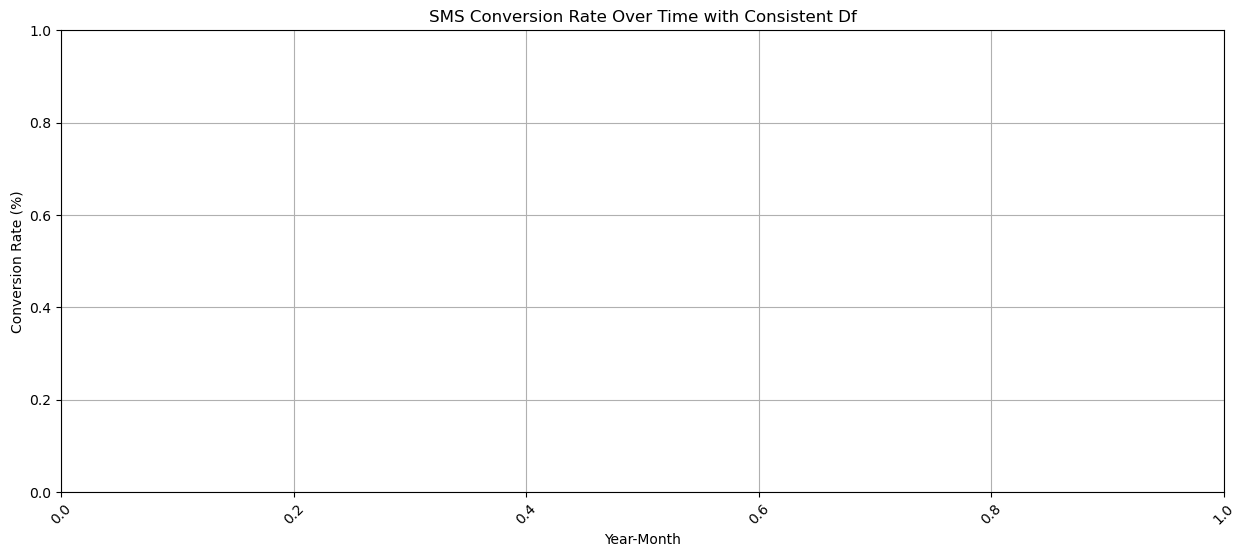

In [41]:
# Filter data for email interactions
email_df = consistent_funnel[(df['Sms Clicks'] == 0) & (consistent_funnel['Email Clicks'] > 0)]

# Filter data for SMS interactions
sms_df = consistent_funnel[(consistent_funnel['Email Clicks'] == 0) & (consistent_funnel['Sms Clicks'] > 0)]

# Plot conversion rate for email interactions
plot_conversion_rate(email_df, 'Email Conversion Rate Over Time with Consistent Df')

# Plot conversion rate for SMS interactions
plot_conversion_rate(sms_df, 'SMS Conversion Rate Over Time with Consistent Df')


We have observed that there is no significant change in the conversion rate trend when comparing the original dataset prior to 2023. 

However, a noticeable shift has occurred in recent months and also we separate Sms from Emails

## Assumptions
I will assume that the inconsistencies observed are a result of the specific time window captured in this dataset. It's likely that clients who don't have a record of Emails or SMS being sent were actually contacted, but that information is not available in this sample. Despite this, it should not hinder our ability to continue with further hypothesis testing and analysis.

# "User Phone Timezone"

A good hypothesis to investigate could be that the time zone in which customers are contacted has a significant impact on the conversion rate. The logic behind this hypothesis is that the timing of notifications (whether by email or SMS) could affect the likelihood of the customer interacting with them. For example, a message sent in the middle of the night based on the customer's time zone is less likely to be opened and therefore lead to a successful conversion.

### Rationale for removing "Unknown Timezone"
We can justify deleting records with "Unknown Timezone" for this specific analysis because that data does not provide us with information about the client's time zone. Without this information, we cannot effectively evaluate the impact of time zone on conversion rate. Additionally, missing time zone data could introduce noise into the analysis, making it difficult to identify meaningful patterns.


If we want to test the conclussions with the consistent funnel we can uncomment the next line

In [42]:
#df = consistent_funnel 

In [43]:
df["User Phone Timezone"].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

User Phone Timezone
CST        0.578547
EST        0.313451
Unknown    0.059401
PST        0.031419
MST        0.013255
AST        0.001964
UTC-10     0.001227
UTC-9      0.000736
Name: proportion, dtype: float64

In [44]:
df_tz = df[df["User Phone Timezone"]!= "Unknown"]

In [45]:
timezone_format = {'EST':'America/New_York', 
            'CST':'America/Chicago', 
            'PST':'America/Los_Angeles',
            'MST':'America/Denver',
            'AST':'America/Puerto_Rico',
                   'UTC-10':'Pacific/Honolulu',
                     'UTC-9':'America/Anchorage'
                   }

df_tz['hrs-pyz'] = df_tz["User Phone Timezone"].map(timezone_format)

/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/347409002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['hrs-pyz'] = df_tz["User Phone Timezone"].map(timezone_format)


In [46]:
df_tz['hrs-pyz'].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

hrs-pyz
America/Chicago        0.615084
America/New_York       0.333246
America/Los_Angeles    0.033403
America/Denver         0.014092
America/Puerto_Rico    0.002088
Pacific/Honolulu       0.001305
America/Anchorage      0.000783
Name: proportion, dtype: float64

## Convert to client timezone

In [47]:
import pytz
import pandas as pd

def convert_to_local_time(row):
    try:
        if pd.isnull(row['Created At']) or row['User Phone Timezone'] is None:
            return row['Created At']
        
        local_tz = pytz.timezone(row['hrs-pyz'])
        
        if row['Created At'].tzinfo is not None:
            local_time = row['Created At'].astimezone(local_tz)
        else:  
            utc_time = pytz.utc.localize(row['Created At'])
            local_time = utc_time.astimezone(local_tz)
        
        return local_time
    except Exception as e:
        print(f"Row with error {row['Created At']} -> to {row['hrs-pyz']}")
        return row['Created At']
    
df_tz['local_time'] = df_tz.apply(convert_to_local_time, axis=1)
df_tz

/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/3000293768.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['local_time'] = df_tz.apply(convert_to_local_time, axis=1)


,Client Domain,User Phone Timezone,Created At,Email Clicks,Email Opens,Emails,Expired,Order Funnel State,Sms,Sms Clicks,...,Platforms Order Group - Order → Manager,Platforms Order Group - Order → Source,order_has_user_email,order_has_user_phone,funnel_order,Day,Month,Year,hrs-pyz,local_time
194,A,EST,2023-01-20 19:03:11.624372+00:00,2,0,4.0,1,6-Employer selected,1.0,1,...,masked@order_manager.org,internal,True,True,6,20,1,2023,America/New_York,2023-01-20 14:03:11.624372-05:00
195,A,EST,2022-07-12 17:44:08.149542+00:00,1,1,1.0,0,9-Completed,1.0,1,...,masked@order_manager.org,internal,True,True,9,12,7,2022,America/New_York,2022-07-12 13:44:08.149542-04:00
196,A,EST,2022-08-08 20:24:56.757669+00:00,1,1,1.0,0,9-Completed,1.0,0,...,masked@order_manager.org,internal,True,True,9,8,8,2022,America/New_York,2022-08-08 16:24:56.757669-04:00
197,A,EST,2022-11-28 17:32:59.758117+00:00,0,4,4.0,1,7-Viewed provider login,1.0,1,...,masked@order_manager.org,internal,True,True,7,28,11,2022,America/New_York,2022-11-28 12:32:59.758117-05:00
198,A,EST,2022-07-07 15:39:00.538025+00:00,4,4,4.0,1,5-Widget loaded,1.0,1,...,masked@order_manager.org,internal,True,True,5,7,7,2022,America/New_York,2022-07-07 11:39:00.538025-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4032,A,CST,2022-07-18 18:21:37.529621+00:00,1,1,4.0,1,7-Viewed provider login,1.0,0,...,masked@order_manager.org,internal,True,True,7,18,7,2022,America/Chicago,2022-07-18 13:21:37.529621-05:00
4033,A,CST,2022-07-14 18:19:03.889063+00:00,0,0,4.0,1,8-Submitted login,1.0,1,...,masked@order_manager.org,internal,True,True,8,14,7,2022,America/Chicago,2022-07-14 13:19:03.889063-05:00
4034,A,CST,2022-08-18 20:30:09.688551+00:00,0,0,0.0,1,7-Viewed provider login,1.0,1,...,masked@order_manager.org,internal,False,True,7,18,8,2022,America/Chicago,2022-08-18 15:30:09.688551-05:00
4035,A,EST,2022-10-27 18:09:06.743787+00:00,0,0,0.0,1,7-Viewed provider login,1.0,1,...,masked@order_manager.org,internal,False,True,7,27,10,2022,America/New_York,2022-10-27 14:09:06.743787-04:00


### Hour of the call

In [48]:
def check_hour(horario):
    horario = str(horario)
    return horario.split(" ")[1].split(":")[0]

df_tz['local_time_apply'] = df_tz['local_time'].apply(check_hour)

/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/3983244431.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['local_time_apply'] = df_tz['local_time'].apply(check_hour)


In [49]:
df_tz['local_time_apply'] = df_tz['local_time_apply'].astype(int)

/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/2750846577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz['local_time_apply'] = df_tz['local_time_apply'].astype(int)


<Axes: xlabel='local_time_apply', ylabel='Count'>

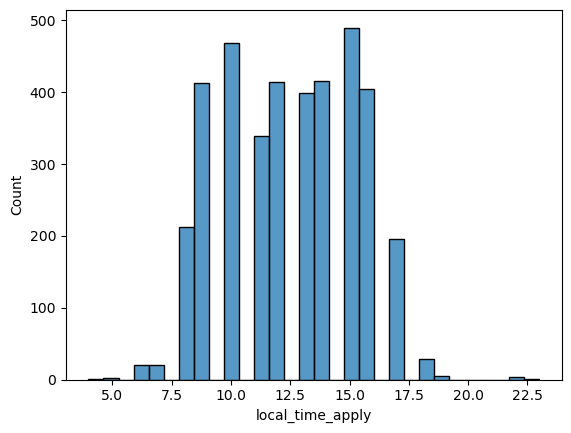

In [50]:
import seaborn as sns

sns.histplot(data=df_tz, x="local_time_apply")


In [51]:
df_tz["conversion"] = df_tz['Order Funnel State'] == "9-Completed"

df_tz["conversion"] = df_tz["conversion"].astype(int)

conv_df = df_tz.groupby('local_time_apply', as_index=True).agg(cant_conversion = ("conversion","sum"),
                                       totales = ("conversion","count") )

conv_df["%_conversion"] = conv_df["cant_conversion"]/conv_df["totales"]
conv_df

/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/1346153316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz["conversion"] = df_tz['Order Funnel State'] == "9-Completed"
/var/folders/xx/hcklcr8s0rxd7p5fz63z342w0000gn/T/ipykernel_20049/1346153316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tz["conversion"] = df_tz["conversion"].astype(int)


,cant_conversion,totales,%_conversion
local_time_apply,,,
4,1,1,1.000000
5,0,2,0.000000
6,5,20,0.250000
7,2,20,0.100000
8,37,213,0.173709
9,72,413,0.174334
10,74,468,0.158120
11,48,339,0.141593
12,73,414,0.176329


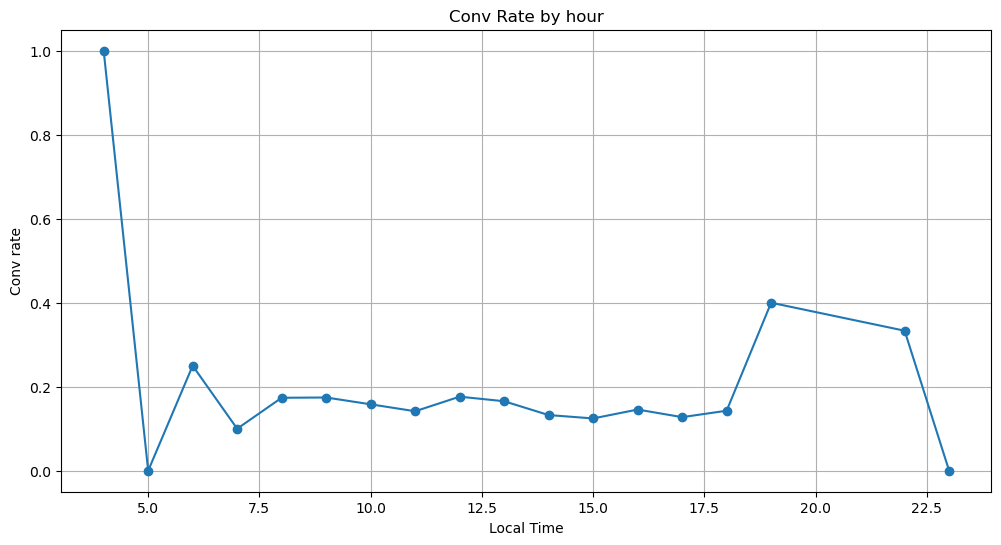

In [52]:
conv_df = conv_df.sort_index()

# Crear el gráfico
plt.figure(figsize=(12, 6))

plt.plot(conv_df.index, conv_df['%_conversion'], marker='o')

plt.title('Conv Rate by hour')
plt.xlabel('Local Time')
plt.ylabel('Conv rate')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [53]:
conv_df_by_tz = df_tz.groupby(['hrs-pyz','local_time_apply'], as_index=True).agg(cant_conversion = ("conversion","sum"),
                                       totales = ("conversion","count") )

conv_df_by_tz["%_conversion"] = conv_df_by_tz["cant_conversion"]/conv_df_by_tz["totales"]
conv_df_by_tz

cant_conversion  totales  %_conversion
hrs-pyz             local_time_apply                                        
America/Anchorage   5                               0        1      0.000000
                    7                               0        1      0.000000
                    13                              0        1      0.000000
America/Chicago     7                               0        2      0.000000
                    8                              35      191      0.183246
                    9                              40      281      0.142349
                    10                             32      299      0.107023
                    11                             30      178      0.168539
                    12                             47      251      0.187251
                    13                             35      231      0.151515
                    14                             34      248      0.137097
                    15                             40      338      0.118343
                    16                             37      282      0.131206
                    17                              9       47      0.191489
                    18                              0        7      0.000000
                    22                              1        2      0.500000
America/Denver      7                               0        4      0.000000
                    8                               1        6      0.166667
                    9                               2        8      0.250000
                    10                              2        4      0.500000
                    11                              3        5      0.600000
                    12                              1        8      0.125000
                    13                              0        6      0.000000
                    14                              0        9      0.000000
                    15                              0        4      0.000000
America/Los_Angeles 5                               0        1      0.000000
                    6                               5       19      0.263158
                    7                               2       13      0.153846
                    8                               1       16      0.062500
                    9                               1       14      0.071429
                    10                              2       13      0.153846
                    11                              1       10      0.100000
                    12                              1       11      0.090909
                    13                              1       12      0.083333
                    14                              1       19      0.052632
America/New_York    9                              29      110      0.263636
                    10                             37      150      0.246667
                    11                             14      141      0.099291
                    12                             24      143      0.167832
                    13                             30      149      0.201342
                    14                             20      139      0.143885
                    15                             21      148      0.141892
                    16                             22      122      0.180328
                    17                             16      147      0.108844
                    18                              4       21      0.190476
                    19                              2        5      0.400000
                    22                              0        1      0.000000
                    23                              0        1      0.000000
America/Puerto_Rico 10                              1        2      0.500000
                    11                              0        2      0.000000
                    12            

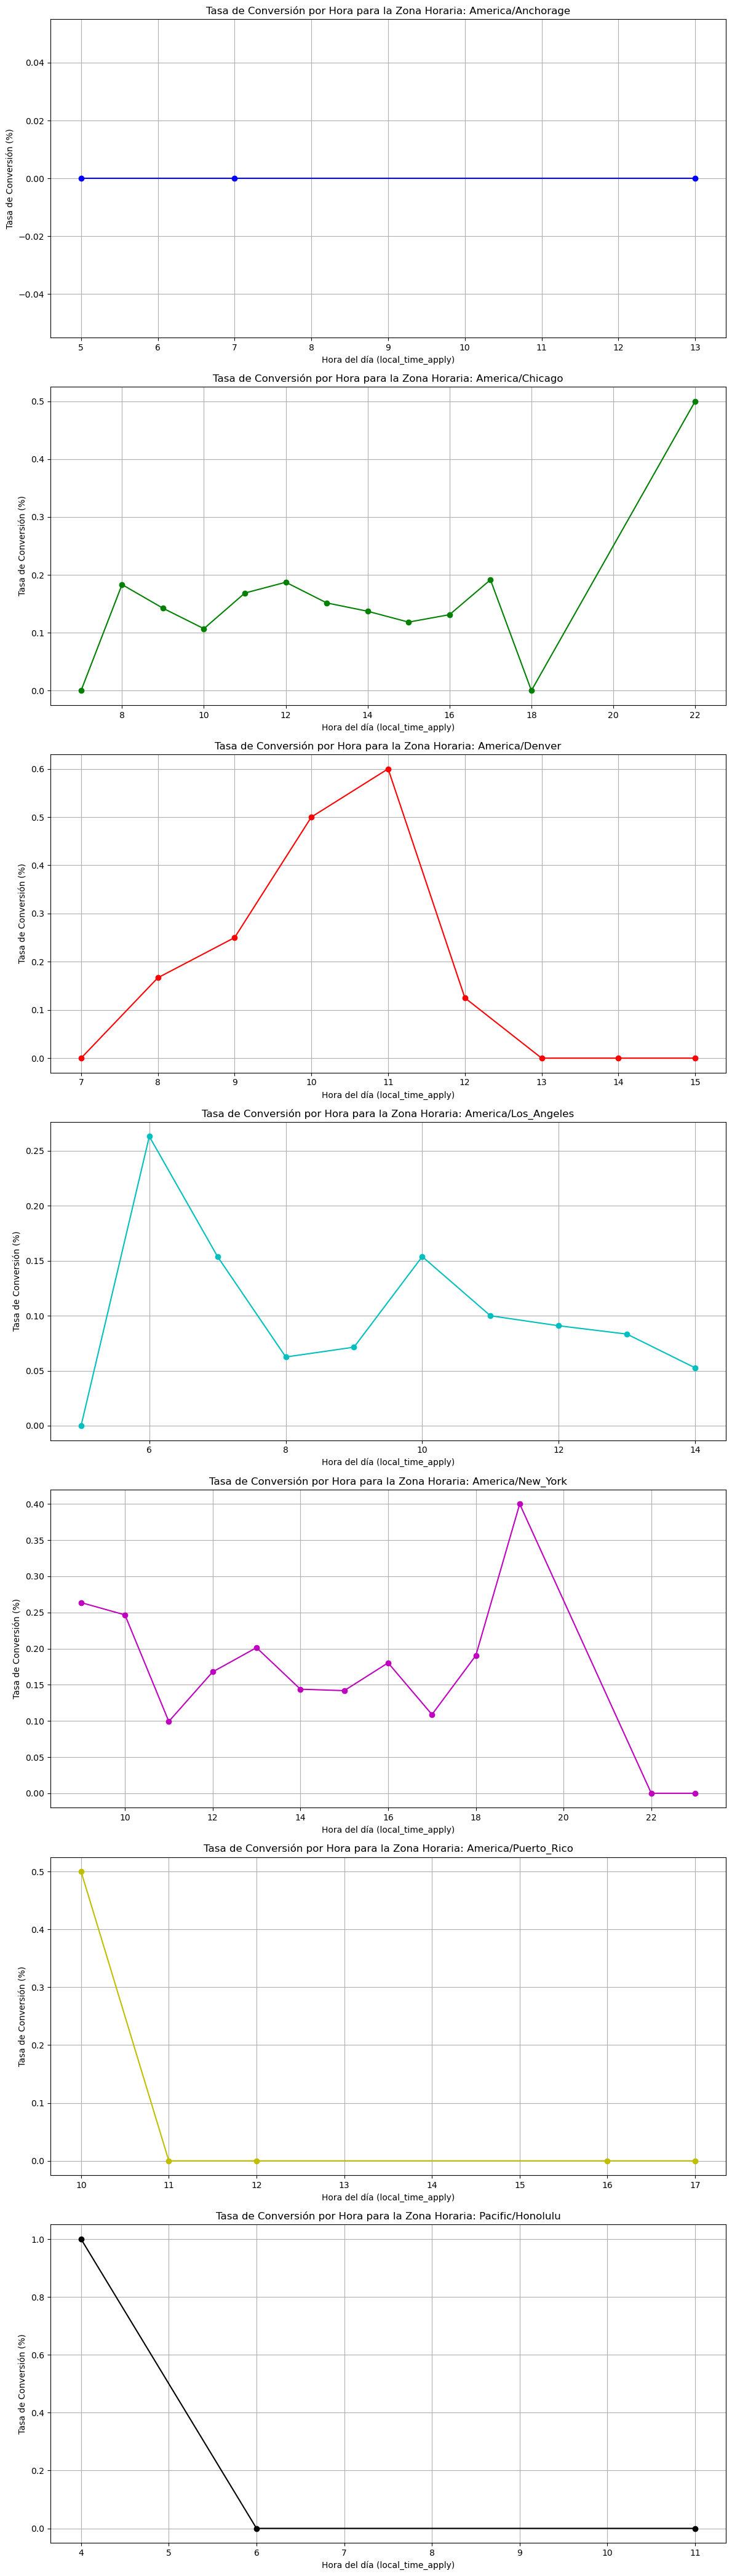

In [54]:
import matplotlib.pyplot as plt

# Ordenar el DataFrame por 'hrs-pyz' y 'local_time_apply'
conv_df_by_tz = conv_df_by_tz.sort_index()

# Obtener las zonas horarias únicas
unique_timezones = conv_df_by_tz.index.get_level_values('hrs-pyz').unique()

# Calcular el número de subgráficos necesarios
n_timezones = len(unique_timezones)

# Lista de colores
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Crear subgráficos
fig, axes = plt.subplots(n_timezones, 1, figsize=(12, 6 * n_timezones))

for i, tz in enumerate(unique_timezones):
    ax = axes[i]
    subset = conv_df_by_tz.loc[tz]
    
    # Seleccionar un color de la lista de colores
    color = colors[i % len(colors)]
    
    ax.plot(subset.index.get_level_values('local_time_apply'), subset['%_conversion'], marker='o', color=color)
    ax.set_title(f'Tasa de Conversión por Hora para la Zona Horaria: {tz}')
    ax.set_xlabel('Hora del día (local_time_apply)')
    ax.set_ylabel('Tasa de Conversión (%)')
    ax.grid(True)

plt.tight_layout()
plt.show()






Analyzing each conversion rate, the following observations can be made:

In the 'America/Anchorage' time zone, there is a 0% conversion rate.
In the 'America/Chicago' time zone, good performance is observed from 8 AM to 5 PM, with another peak occurring after 8 PM.
In the 'America/Denver' time zone, the conversion rate follows a normal distribution, with the peak of the curve occurring at 11 AM.
In the 'America/Los Angeles' time zone, the peak occurs at 6 AM.
In the 'America/New York' time zone, the peak occurs at 7 PM.
In both Puerto Rico and Honolulu, the conversion rate is also 0%.
Recommendation:
Given these observations, it would be most effective to communicate with customers at the times when conversion rates are highest in their respective time zones. Specifically:

For customers in the 'America/Chicago' time zone, focus communication efforts between 8 AM and 5 PM, and consider a secondary push after 8 PM.
For those in the 'America/Denver' time zone, aim to reach out around 11 AM.
In the 'America/Los Angeles' time zone, early morning at 6 AM appears to be the most effective time.
For the 'America/New York' time zone, consider targeting communications around 7 PM.
There is no point in allocating resources for customer outreach in the 'America/Anchorage', Puerto Rico, and Honolulu time zones at this time, given the 0% conversion rates observed.

For further analysis we need to plot this

### Hipotesis Expired


In [55]:
df_tz.groupby("conversion").agg(cantidad_expired =("Expired","sum"),
                            media_expired =("Expired","mean")) 

,cantidad_expired,media_expired
conversion,,
0,2875,0.885433
1,37,0.063248


In [56]:
df_exp = df_tz.groupby("Expired").agg(cant_conv =("conversion","sum"),
                                                     total_de_muestra= ("conversion","count"),
                         tasa_conv =("conversion","mean")) 

df_exp

,cant_conv,total_de_muestra,tasa_conv
Expired,,,
0,557,1077,0.517177
1,21,2630,0.007985
2,5,101,0.049505
3,2,16,0.125000
4,0,8,0.000000


# Model to see conclusions

In [57]:
cols = [
 'Email Clicks',
 'Email Opens',
 'Sms Clicks',
 'Sms Opens',
 'order_has_user_email',
 'order_has_user_phone',
 'hrs-pyz',
 'local_time_apply',
 'conversion']

df_model = df_tz[cols].copy()

In [58]:
df_model = pd.get_dummies(df_model, columns=['hrs-pyz'], drop_first=True)

In [59]:
df_model["order_has_user_email"] = df_model["order_has_user_email"].astype(int)

In [60]:
df_model["order_has_user_phone"] = df_model["order_has_user_phone"].astype(int)

## RF for importance cols

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X = df_model.drop('conversion', axis=1)
y = df_model['conversion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Crear un DataFrame para las importancias de las características
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Seleccionar las características más importantes (por ejemplo, las 10 más importantes)
top_features = feature_importance_df['Feature'][:10].tolist()

print("Top 10 features:", top_features)



Top 10 features: ['Email Opens', 'local_time_apply', 'Sms Clicks', 'Email Clicks', 'order_has_user_email', 'hrs-pyz_America/New_York', 'hrs-pyz_America/Chicago', 'hrs-pyz_America/Denver', 'hrs-pyz_America/Los_Angeles', 'hrs-pyz_Pacific/Honolulu']


Confusion Matrix:
[[640  19]
 [ 81  27]]


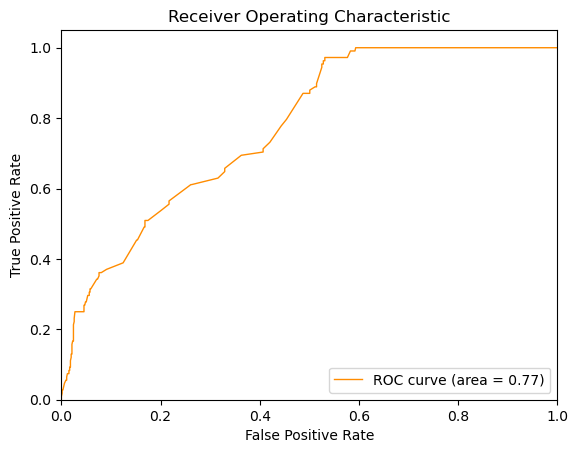

In [62]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
y_pred_prob = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Curva ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


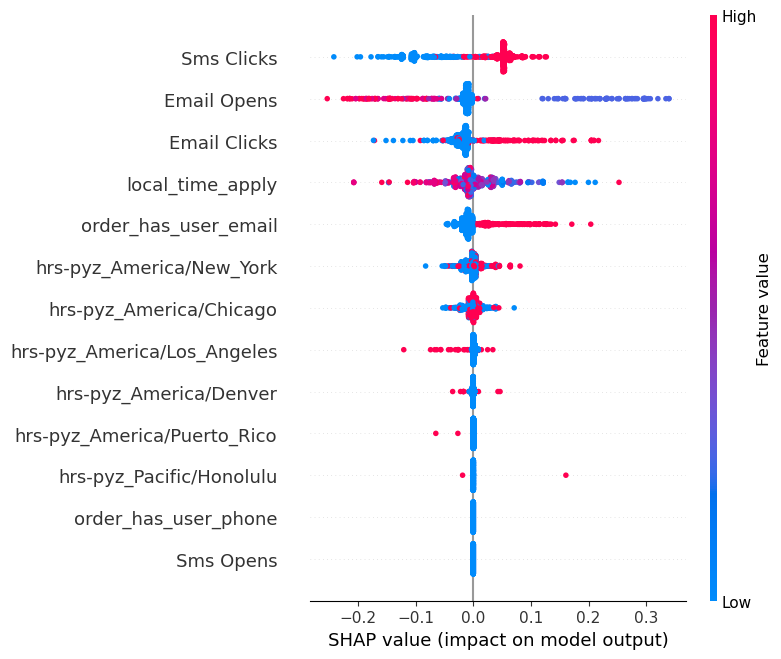

In [63]:
import shap

# Inicializar el explainer de SHAP
explainer = shap.TreeExplainer(rf)

# Calcular los SHAP values para todas las muestras en el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Visualizar el primer prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

# Visualizar el resumen para todo el conjunto de prueba
shap.summary_plot(shap_values[1], X_test)


___

## 1) Analizar order_has_user_email y order_has_user_phone a lo largo del tiempo y compararlo a conversión.

## 2) Crear una notebook con una lógica de comunicación

## 3) Armar 5 slides copiando y pegando cualquier parte de la notebook para comunicar a un gerente no tan técnico

In [64]:
email_a_lo_largo_del_tiempo = df_tz.groupby(["local_time_apply","order_has_user_email"]).agg(cant_conv =("conversion","sum"),
                                                        total_de_muestra= ("conversion","count"),
                            tasa_conv =("conversion","mean"))
email_a_lo_largo_del_tiempo

cant_conv  total_de_muestra  tasa_conv
local_time_apply order_has_user_email                                        
4                False                         1                 1   1.000000
5                False                         0                 2   0.000000
6                False                         1                15   0.066667
                 True                          4                 5   0.800000
7                False                         0                13   0.000000
                 True                          2                 7   0.285714
8                False                        20               166   0.120482
                 True                         17                47   0.361702
9                False                        34               276   0.123188
                 True                         38               137   0.277372
10               False                        37               303   0.122112
                 True                         37               165   0.224242
11               False                        22               226   0.097345
                 True                         26               113   0.230088
12               False                        35               261   0.134100
                 True                         38               153   0.248366
13               False                        34               281   0.120996
                 True                         32               118   0.271186
14               False                        32               305   0.104918
                 True                         23               110   0.209091
15               False                        37               396   0.093434
                 True                         24                94   0.255319
16               False                        42               318   0.132075
                 True                         17                87   0.195402
17               False                        16               140   0.114286
                 True                          9                56   0.160714
18               False                         1                23   0.043478
                 True                          3                 5   0.600000
19               False                         2                 4   0.500000
                 True                          0                 1   0.000000
22               False                         1                 2   0.500000
                 True                          0                 1   0.000000
23               False                         0                 1   0.000000

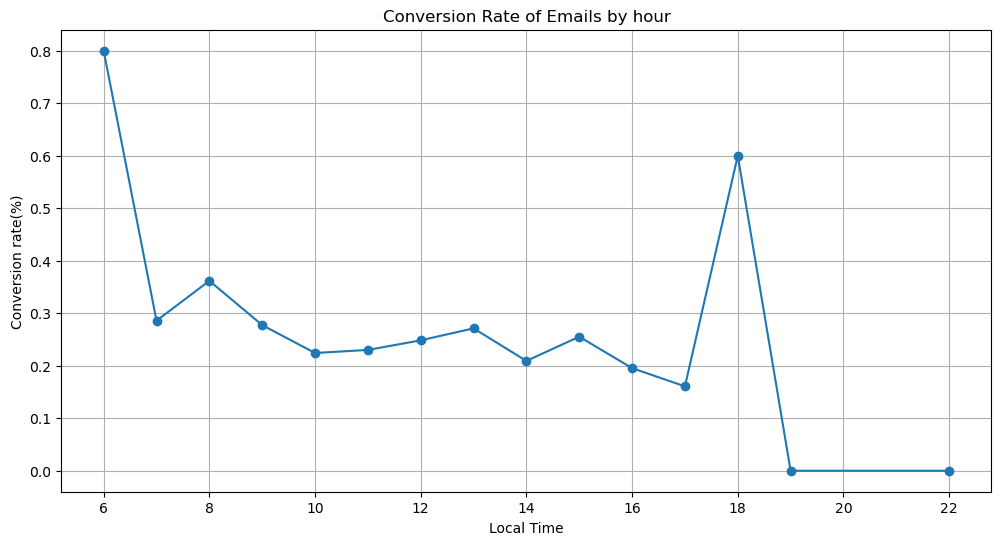

In [65]:
email_a_lo_largo_del_tiempo = email_a_lo_largo_del_tiempo.reset_index()
plt.figure(figsize=(12, 6))
plt.plot(email_a_lo_largo_del_tiempo[email_a_lo_largo_del_tiempo["order_has_user_email"]==1]["local_time_apply"], email_a_lo_largo_del_tiempo[email_a_lo_largo_del_tiempo["order_has_user_email"]==1]["tasa_conv"], marker='o')
plt.title('Conversion Rate of Emails by hour')
plt.xlabel('Local Time')
plt.ylabel('Conversion rate(%)')
plt.grid(True)
plt.show()

In [66]:
phone_a_lo_largo_del_tiempo = df_tz.groupby(["local_time_apply","order_has_user_phone"]).agg(cant_conv =("conversion","sum"),
                                                        total_de_muestra= ("conversion","count"),
                            tasa_conv =("conversion","mean"))

phone_a_lo_largo_del_tiempo

,,cant_conv,total_de_muestra,tasa_conv
local_time_apply,order_has_user_phone,,,
4,True,1,1,1.000000
5,True,0,2,0.000000
6,True,5,20,0.250000
7,True,2,20,0.100000
8,True,37,213,0.173709
9,True,72,413,0.174334
10,True,74,468,0.158120
11,True,48,339,0.141593
12,True,73,414,0.176329


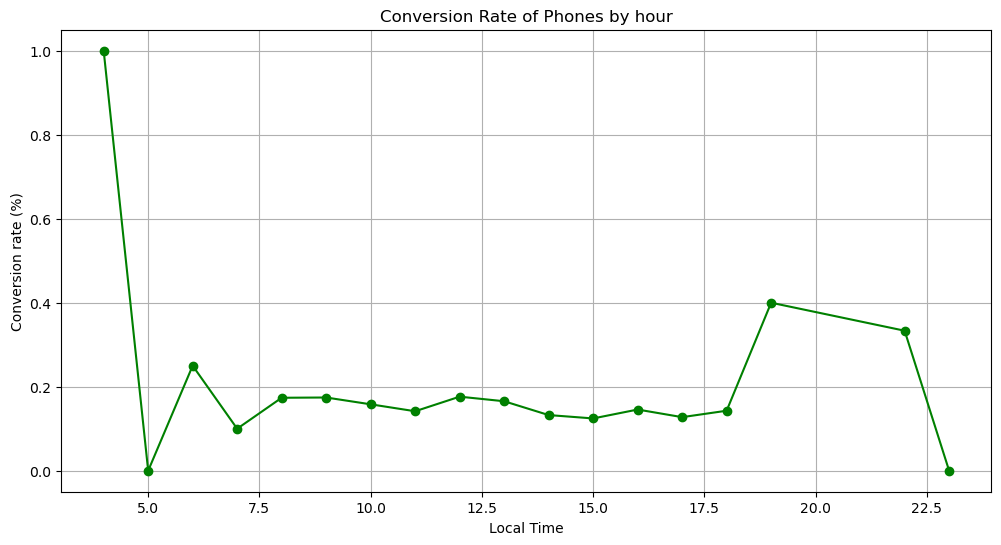

In [67]:
phone_a_lo_largo_del_tiempo = phone_a_lo_largo_del_tiempo.reset_index()
plt.figure(figsize=(12, 6))
plt.plot(phone_a_lo_largo_del_tiempo[phone_a_lo_largo_del_tiempo["order_has_user_phone"]==1]["local_time_apply"], phone_a_lo_largo_del_tiempo[phone_a_lo_largo_del_tiempo["order_has_user_phone"]==1]["tasa_conv"], marker='o', color = "green")
plt.title('Conversion Rate of Phones by hour')
plt.xlabel('Local Time')
plt.ylabel('Conversion rate (%)')
plt.grid(True)
plt.show()

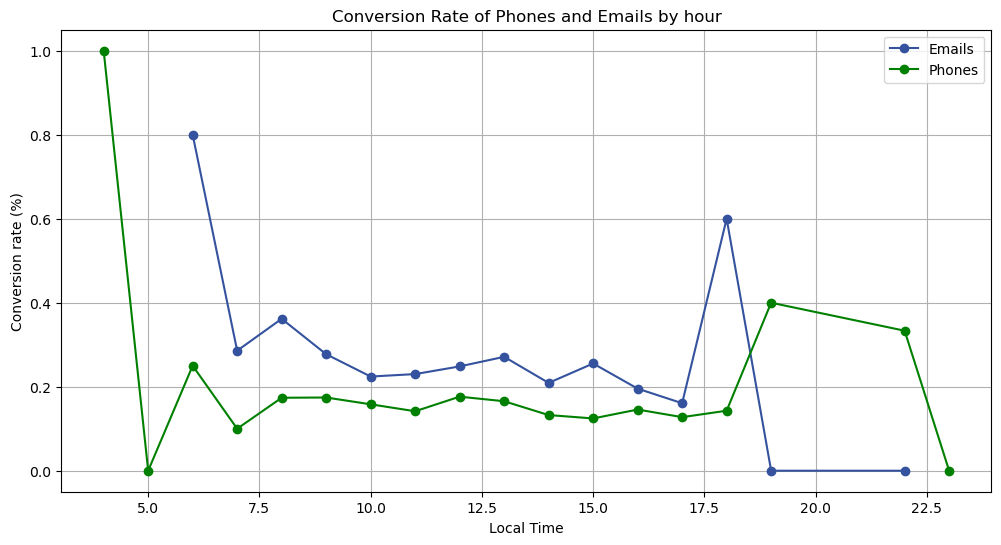

In [68]:
# hacer los dos graficos en 1 

plt.figure(figsize=(12, 6))
plt.plot(email_a_lo_largo_del_tiempo[email_a_lo_largo_del_tiempo["order_has_user_email"]==1]["local_time_apply"], email_a_lo_largo_del_tiempo[email_a_lo_largo_del_tiempo["order_has_user_email"]==1]["tasa_conv"], marker='o', color = "#34529e")
plt.plot(phone_a_lo_largo_del_tiempo[phone_a_lo_largo_del_tiempo["order_has_user_phone"]==1]["local_time_apply"], phone_a_lo_largo_del_tiempo[phone_a_lo_largo_del_tiempo["order_has_user_phone"]==1]["tasa_conv"], marker='o', color = "green")
plt.title('Conversion Rate of Phones and Emails by hour')
plt.xlabel('Local Time')
plt.ylabel('Conversion rate (%)')
plt.grid(True)
plt.legend(["Emails","Phones"])
plt.show()


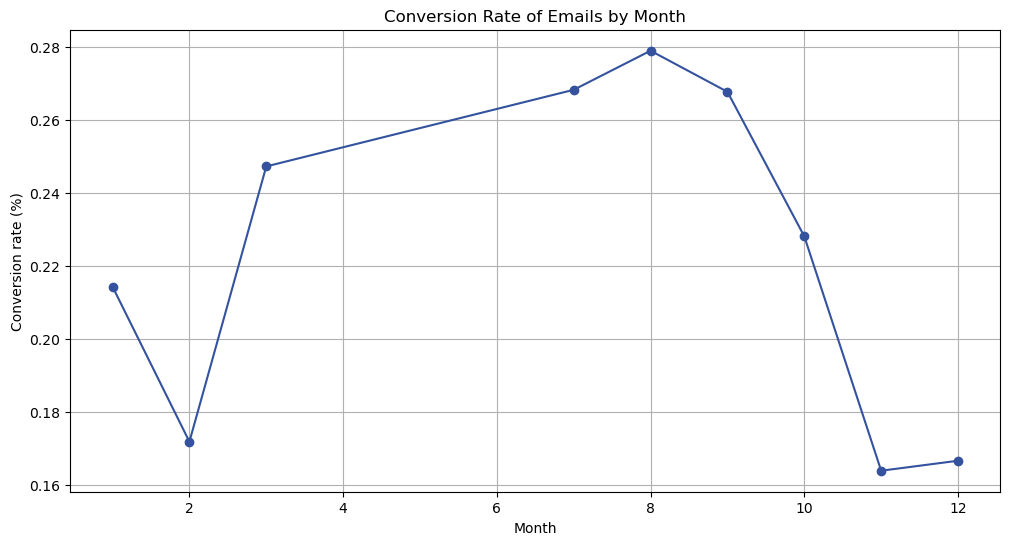

In [69]:
# hacer email_a_lo_largo_del_tiempo mensualmente

email_a_lo_largo_del_tiempo = df_tz.groupby(["Month","order_has_user_email"]).agg(cant_conv =("conversion","sum"),
                                                        total_de_muestra= ("conversion","count"),
                            tasa_conv =("conversion","mean"))

email_a_lo_largo_del_tiempo = email_a_lo_largo_del_tiempo.reset_index()

plt.figure(figsize=(12, 6))
plt.plot(email_a_lo_largo_del_tiempo[email_a_lo_largo_del_tiempo["order_has_user_email"]==1]["Month"], email_a_lo_largo_del_tiempo[email_a_lo_largo_del_tiempo["order_has_user_email"]==1]["tasa_conv"], marker='o', color = "#34529e")
plt.title('Conversion Rate of Emails by Month')
plt.xlabel('Month')
plt.ylabel('Conversion rate (%)')
plt.grid(True)
plt.show()
